## Welcome Back Kagglers 

credit : https://www.kaggle.com/code/ammarali32/imc-2022-kornia-loftr-from-0-533-to-0-721


<center>
    <h2 style="color: #022047"> If you found it useful please upvote  </h2>
</center>

![](https://storage.googleapis.com/kaggle-media/competitions/google-image-matching/trevi-canvas-licensed-nonoderivs.jpg)

# ***Install Libs***

In [1]:
dry_run = False
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl

Processing /kaggle/input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
  Attempting uninstall: kornia
    Found existing installation: kornia 0.5.8
    Uninstalling kornia-0.5.8:
      Successfully uninstalled kornia-0.5.8
Processing /kaggle/input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl


# ***Import dependencies***

In [2]:
import os
import numpy as np
import cv2
import csv
from glob import glob
import torch
import matplotlib.pyplot as plt
import kornia
from kornia_moons.feature import *
import kornia as K
import kornia.feature as KF
import gc


# ***Model***

In [3]:
device = torch.device('cuda')
matcher = KF.LoFTR(pretrained=None)
matcher.load_state_dict(torch.load("../input/kornia-loftr/loftr_outdoor.ckpt")['state_dict'])
matcher = matcher.to(device).eval()

## *Utils*

In [4]:
src = '/kaggle/input/image-matching-challenge-2022/'

test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    '''Convenience function to write CSV files.'''
    
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])


def load_torch_image(fname, device):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device)

# ***Inference***

torch.Size([1, 3, 840, 472])


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


Running time:  6.827770948410034  s
torch.Size([1, 3, 840, 472])
Running time:  0.955782413482666  s
torch.Size([1, 3, 840, 472])
Running time:  1.1465678215026855  s


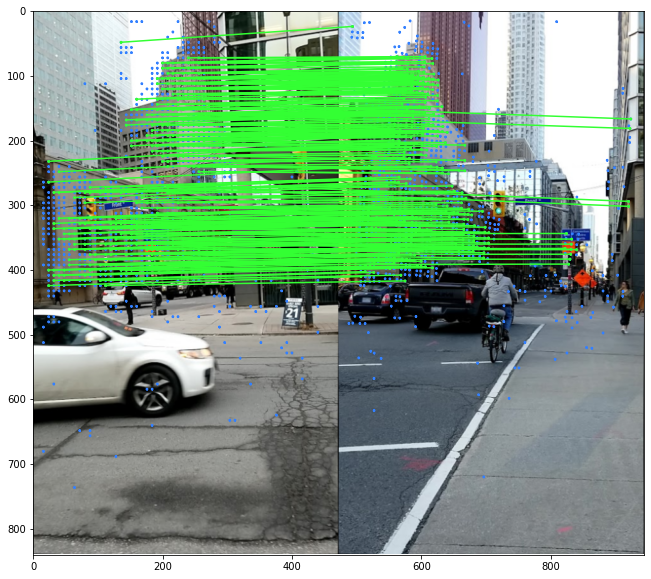

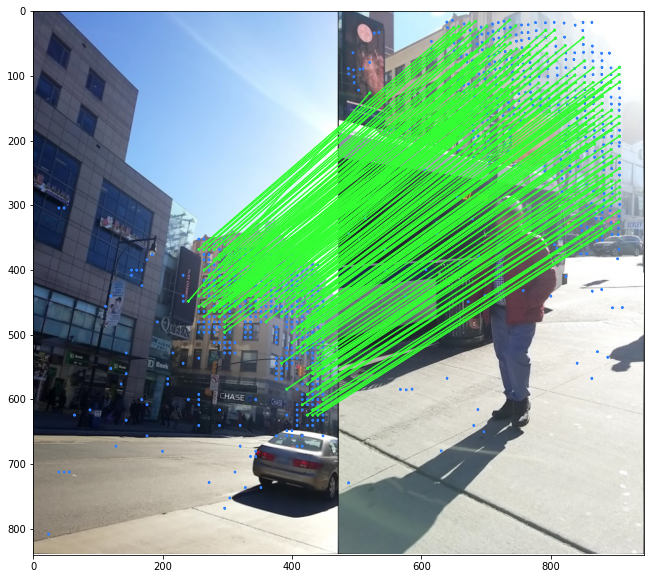

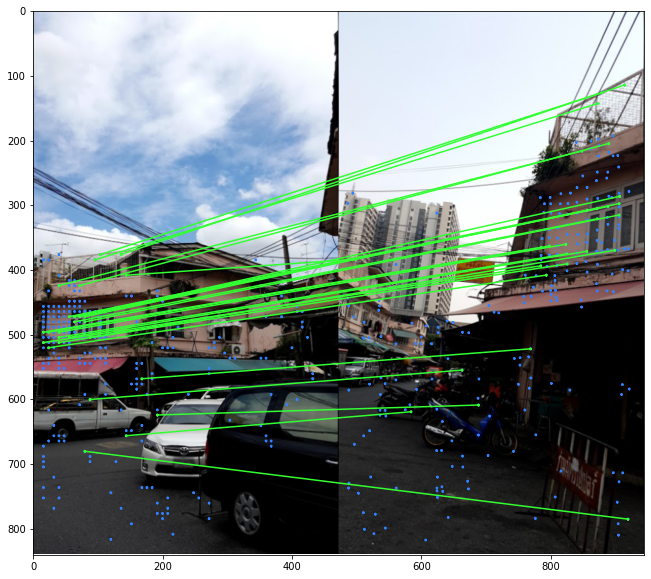

In [5]:
F_dict = {}
import time
for i, row in enumerate(test_samples):
    sample_id, batch_id, image_1_id, image_2_id = row
    # Load the images.
    st = time.time()
    image_1 =load_torch_image(f'{src}/test_images/{batch_id}/{image_1_id}.png', device)
    image_2 = load_torch_image(f'{src}/test_images/{batch_id}/{image_2_id}.png', device)
    print(image_1.shape)
    input_dict = {"image0": K.color.rgb_to_grayscale(image_1), 
              "image1": K.color.rgb_to_grayscale(image_2)}

    with torch.no_grad():
        correspondences = matcher(input_dict)
        
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    
    if len(mkpts0) > 7:
        #F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.25, 0.9999, 100000)
        F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.1845, 0.999999, 220000)
        inliers = inliers > 0
        assert F.shape == (3, 3), 'Malformed F?'
        F_dict[sample_id] = F
    else:
        F_dict[sample_id] = np.zeros((3, 3))
        continue
    gc.collect()
    nd = time.time()    
    if (i < 3):
        print("Running time: ", nd - st, " s")
        draw_LAF_matches(
        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
        torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
        K.tensor_to_image(image_1),
        K.tensor_to_image(image_2),
        inliers,
        draw_dict={'inlier_color': (0.2, 1, 0.2),
                   'tentative_color': None, 
                   'feature_color': (0.2, 0.5, 1), 'vertical': False})
    
with open('submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in F_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(F)}\n')

<center>
    <h2 style="color: #022047"> Thanks for reading 🤗  </h2>
</center>